In [2]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Contacts import contacts_df
#from Spend import spend_df
from Calls import calls_df
import matplotlib.pyplot as plt

In [3]:
# Загрузка данных из Excel файла
file_path = 'update_spend.xlsx'
spend_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(spend_df.head())

        Date        Source                   Campaign  Impressions  Spend  \
0 2023-07-03    Google Ads             gen_analyst_DE            6   0.00   
1 2023-07-03    Google Ads      performancemax_eng_DE            4   0.01   
2 2023-07-03  Facebook Ads          20.03.24_widde_PL            0   0.00   
3 2023-07-03    Google Ads  12.09.23interests_Uxui_DE            0   0.00   
4 2023-07-03           CRM               15.07.23b_DE            0   0.00   

   Clicks AdGroup   Ad   Z_score  
0       0     NaN  NaN -0.268904  
1       1     NaN  NaN -0.268530  
2       0     NaN  NaN -0.268904  
3       0     NaN  NaN -0.268904  
4       0     NaN  NaN -0.268904  


In [4]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

                       Campaign  num_leads  num_conversions  conversion_rate  \
0              01.04.23women_PL         43                1         2.325581   
1               02.05.24test_DE        162                4         2.469136   
2               02.07.23wide_DE       1306               64         4.900459   
3                 03.07.23women        789               42         5.323194   
4      04.07.23recentlymoved_DE       1009               41         4.063429   
5          05.07.23interests_DE         51                1         1.960784   
6             05.09.2023wide_DE          9                2        22.222222   
7                07.07.23LAL_DE        704               36         5.113636   
8       08.04.24wide_webinar_DE        352                2         0.568182   
9       08.06.24wide_webinar_DE        149                2         1.342282   
10            12.07.2023wide_DE       2149               82         3.815728   
11    12.09.23interests_Uxui_DE        7

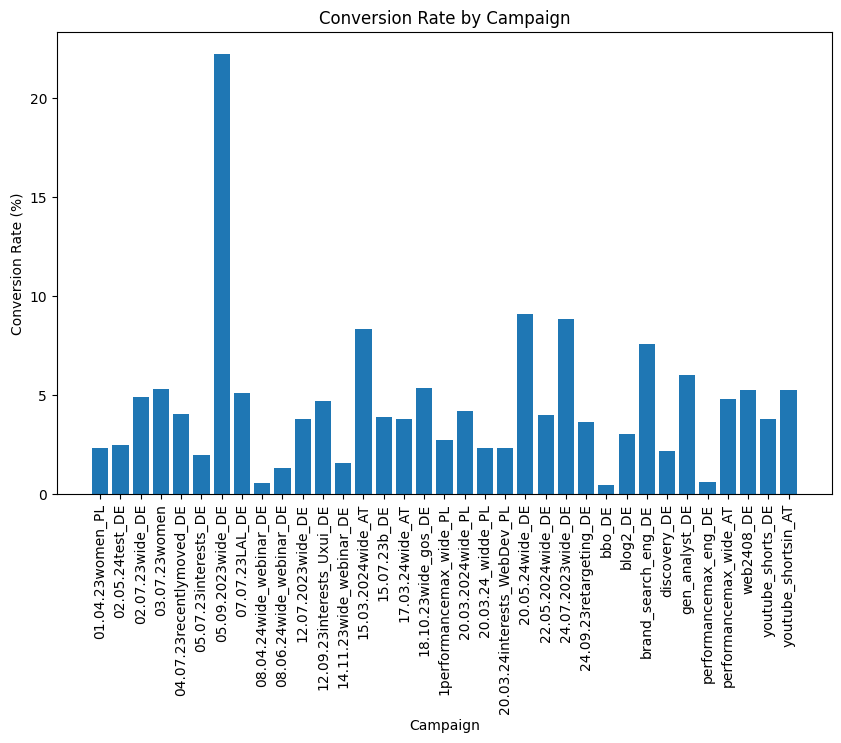

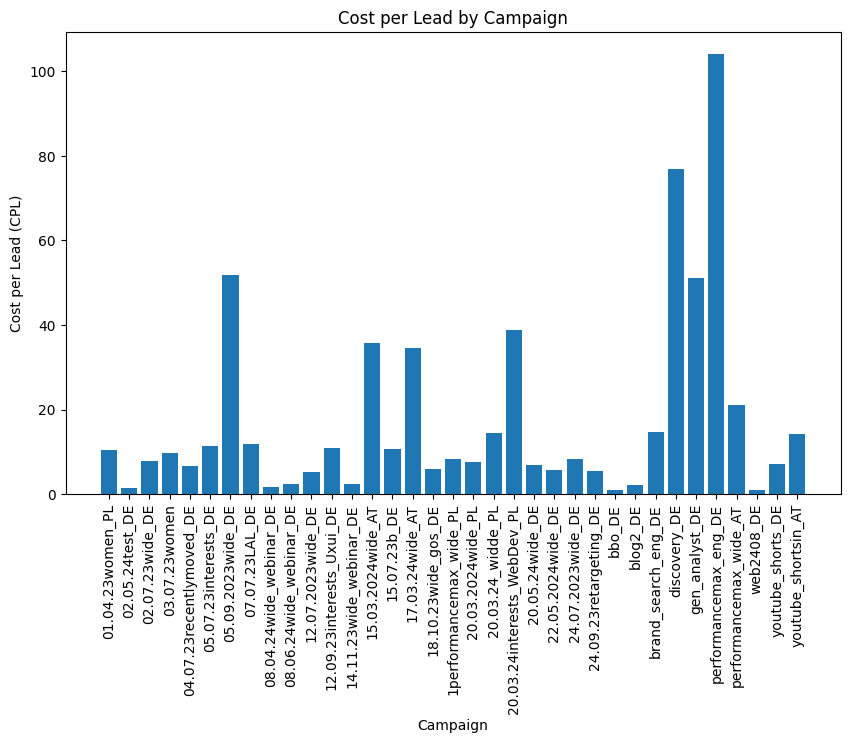

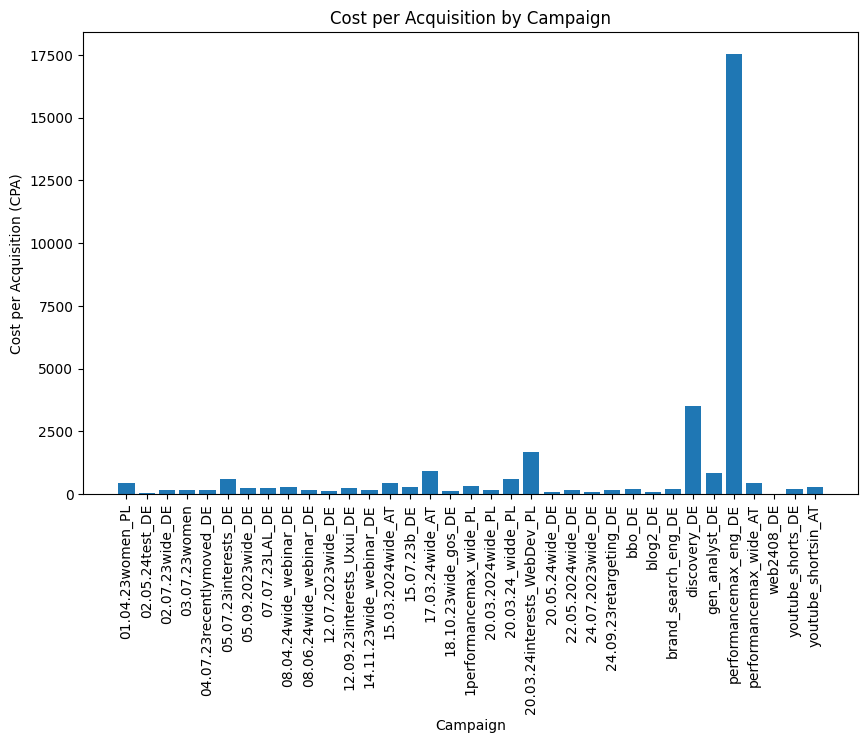

In [6]:
# 1. Подсчет количества лидов по кампаниям
leads_per_campaign = deals_df.groupby('Campaign').size().reset_index(name='num_leads')

# 2. Подсчет количества закрытых сделок (конверсий)
conversions_per_campaign = deals_df[deals_df['Stage'] == 'Payment Done'].groupby('Campaign').size().reset_index(name='num_conversions')

# 3. Подсчет коэффициента конверсии
conversion_rate = conversions_per_campaign.merge(leads_per_campaign, on='Campaign')
conversion_rate['conversion_rate'] = (conversion_rate['num_conversions'] / conversion_rate['num_leads']) * 100

# 4. Подсчет затрат на кампании и расчет CPL и CPA
campaign_spend = spend_df.groupby('Campaign')['Spend'].sum().reset_index()
campaign_efficiency = conversion_rate.merge(campaign_spend, on='Campaign')

# Расчет стоимости лида (CPL) и стоимости конверсии (CPA)
campaign_efficiency['CPL'] = campaign_efficiency['Spend'] / campaign_efficiency['num_leads']
campaign_efficiency['CPA'] = campaign_efficiency['Spend'] / campaign_efficiency['num_conversions']

# 5. Анализ данных
# Выводим результат для анализа
print(campaign_efficiency[['Campaign', 'num_leads', 'num_conversions', 'conversion_rate', 'CPL', 'CPA']])

# График коэффициента конверсии по кампаниям
plt.figure(figsize=(10,6))
plt.bar(campaign_efficiency['Campaign'], campaign_efficiency['conversion_rate'])
plt.xlabel('Campaign')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Campaign')
plt.xticks(rotation=90)
plt.show()

# График стоимости лида по кампаниям
plt.figure(figsize=(10,6))
plt.bar(campaign_efficiency['Campaign'], campaign_efficiency['CPL'])
plt.xlabel('Campaign')
plt.ylabel('Cost per Lead (CPL)')
plt.title('Cost per Lead by Campaign')
plt.xticks(rotation=90)
plt.show()

# График стоимости конверсии по кампаниям
plt.figure(figsize=(10,6))
plt.bar(campaign_efficiency['Campaign'], campaign_efficiency['CPA'])
plt.xlabel('Campaign')
plt.ylabel('Cost per Acquisition (CPA)')
plt.title('Cost per Acquisition by Campaign')
plt.xticks(rotation=90)
plt.show()

### На представленном графике Conversion Rate by Campaign  отображена конверсия (%) по различным рекламным кампаниям. 
График помогает визуально оценить эффективность каждой кампании в терминах конверсии.

Основные наблюдения:
Высокая конверсия:
Одна из кампаний (07.26/Interest6_wide_DE) показывает аномально высокую конверсию, превышающую 20%. Это может свидетельствовать о 
чрезвычайно успешной кампании, либо о возможных аномалиях в данных, которые требуют дальнейшего анализа.

Умеренная конверсия:
Несколько кампаний показывают конверсию в диапазоне от 5% до 10%, что также является хорошим результатом. Эти кампании можно 
рассматривать как успешные и подходящие для дальнейшего масштабирования или анализа успешных практик.

Низкая конверсия:
Большинство кампаний имеют конверсию ниже 5%. Это указывает на то, что они менее эффективны с точки зрения привлечения качественных лидов.
В таких случаях стоит рассмотреть оптимизацию стратегий этих кампаний или даже их закрытие.
    
Равномерность распределения:
Большая часть кампаний имеет схожие показатели конверсии, что говорит о стабильной работе, но при этом можно задуматься о причинах 
отсутствия явных лидеров, кроме упомянутой выше аномальной кампании.
    
Необходимость дальнейшего анализа:
Выявление причин высокой конверсии у отдельных кампаний, а также понимание факторов, которые влияют на низкую конверсию у других. 
Возможно, стоит проанализировать качество аудитории, содержание рекламы, условия и предложения, и т.д.
    
Заключение:
График ясно демонстрирует, что эффективность рекламных кампаний значительно варьируется. Особенно выделяется одна кампания с 
чрезвычайно высокой конверсией. Важно более детально проанализировать данные, чтобы понять, почему некоторые кампании настолько успешны, 
а другие показывают средние или низкие результаты. 
Это поможет оптимизировать рекламные бюджеты и стратегии в будущем.

### На предоставленном графике показана стоимость лида (Cost per Lead, CPL) для различных рекламных кампаний. 
Проанализируем основные моменты:

Основные наблюдения:
Высокая стоимость лида (CPL):

Несколько кампаний показывают очень высокую стоимость лида, особенно brand_search_eng1_DE, которая превышает 100 единиц. 
Это означает, что для привлечения одного лида в рамках этих кампаний затрачивается значительное количество ресурсов.
Кампании с высокой CPL требуют особого внимания. Возможно, стоит пересмотреть стратегию или таргетинг этих кампаний, чтобы 
снизить затраты или увеличить их эффективность.
Умеренная стоимость лида (CPL):

Большинство кампаний имеют стоимость лида в диапазоне от 10 до 40 единиц. Это умеренный показатель, который может быть допустимым, 
если такие лиды демонстрируют высокий коэффициент конверсии и приносят значительный доход.
Тем не менее, стоит проанализировать, возможно ли снизить CPL без потери качества лидов.
Низкая стоимость лида (CPL):

Есть несколько кампаний с очень низкой CPL, что свидетельствует о высокой эффективности этих кампаний с точки зрения затрат на привлечение лидов.
Кампании с низкой CPL могут быть хорошими кандидатами для масштабирования, особенно если они также демонстрируют хорошие показатели конверсии и ROI.
Сравнение с конверсией:

Глядя на график CPL, важно сравнить эти данные с графиком конверсии (предыдущий анализ). Если кампания с высоким CPL также 
имеет высокую конверсию, это может оправдывать высокие затраты.
Напротив, если кампания с высоким CPL имеет низкую конверсию, это может свидетельствовать о низкой эффективности и необходимости 
оптимизации или прекращения такой кампании.
Рекомендации:
Оптимизация кампаний с высокой CPL:

Кампании с высокой стоимостью лида требуют анализа их таргетинга, креативов и условий размещения. Возможно, стоит пересмотреть 
стратегии, чтобы снизить затраты или повысить их эффективность.
Масштабирование успешных кампаний:

Кампании с низкой CPL и высоким коэффициентом конверсии могут быть масштабированы для увеличения объема лидов, сохраняя при этом приемлемые затраты.
Анализ факторов:

Разработайте детальный анализ факторов, которые влияют на стоимость лида, например, канал продвижения, целевая аудитория, время 
    размещения рекламы и т.д. Это поможет лучше понять, какие элементы кампаний можно улучшить для снижения CPL.
Связь с доходностью:

CPL — это важный показатель, но не единственный. Необходимо также учитывать общую доходность и ROI кампаний. Если кампания с высокой 
    CPL приносит значительный доход, она все еще может быть оправдана.
Заключение:
Этот анализ стоимости лида показывает значительные различия между кампаниями. Рекомендую сосредоточиться на оптимизации дорогих кампаний 
    и использовании успешных стратегий из кампаний с низкой CPL для улучшения общей эффективности маркетингового бюджета.

### На предоставленном графике показана стоимость привлечения одного клиента (Cost per Acquisition, CPA) для различных 
рекламных кампаний. CPA — это ключевой показатель, который демонстрирует, сколько стоит привлечь одного клиента в рамках каждой рекламной кампании. 

**Основные выводы**:

**Кампании с высокой CPA**:
Brand_search_eng1_DE демонстрирует аномально высокую стоимость привлечения, превышающую 17 500 единиц. Это крайне высокая стоимость, которая может указывать на низкую эффективность этой кампании. Вероятно, либо в кампании привлекается слишком мало клиентов за большие деньги, либо имеются проблемы с данными, которые требуют проверки.
Некоторые другие кампании также показывают высокую CPA, хотя их значение значительно ниже. Эти кампании также стоит пересмотреть, 
чтобы понять, можно ли снизить их CPA без ущерба для эффективности.

**Кампании с умеренной CPA**:
У большинства кампаний CPA находится в диапазоне до 500 единиц. Это может считаться нормальным показателем, если привлекаемые клиенты приносят значительную прибыль. Тем не менее, даже в этом диапазоне есть возможность для оптимизации, чтобы снизить расходы на привлечение клиентов.

**Кампании с низкой CPA**:
Кампании с низким CPA (меньше 100 единиц) показывают высокую эффективность с точки зрения затрат на привлечение клиентов. Это положительный сигнал, 
и такие кампании могут быть расширены или использованы в качестве примера для улучшения других кампаний.

**Распределение значений CPA**:
Мы видим значительную разницу в стоимости привлечения между кампаниями, что говорит о том, что разные кампании работают с разной эффективностью.
Это может быть связано с различиями в целевой аудитории, креативами, местами размещения рекламы и другими факторами.

**Рекомендации**:
**Оптимизация кампаний с высокой CPA**:
Кампании с очень высокой стоимостью привлечения требуют детального анализа. В первую очередь следует выяснить, почему затраты на привлечение настолько высоки, и можно ли предпринять шаги для их снижения. В некоторых случаях может потребоваться кардинальный пересмотр стратегии или даже остановка кампании.

**Масштабирование успешных кампаний**:
Кампании с низкой CPA и высокой рентабельностью должны быть рассмотрены для масштабирования. Эти кампании показывают, что они привлекают клиентов эффективно, что делает их хорошими кандидатами для увеличения бюджета и объема.

**Анализ причин различий**:
Следует проанализировать, какие факторы влияют на высокие или низкие показатели CPA. Это может включать анализ целевых сегментов аудитории, рекламных креативов, стратегий ставок и других параметров кампаний.

**Связь с ROI**:
Стоит также рассмотреть CPA в контексте общей рентабельности (ROI) кампаний. Важно не только уменьшить CPA, но и обеспечить, чтобы привлекаемые клиенты приносили достаточную прибыль для оправдания расходов.

**Заключение**:
Этот график демонстрирует, что стоимость привлечения клиентов значительно варьируется между различными рекламными кампаниями. Кампании с высокой CPA требуют внимания и, возможно, оптимизации, в то время как успешные кампании с низкой CPA должны быть масштабированы для достижения наилучших результатов. Важно также учитывать общий контекст и доходность кампаний, чтобы принимать обоснованные решения.

### Оцените эффективность различных маркетинговых источников (Source) в генерировании качественных лидов.

### План анализа:
Классификация лидов по качеству:

Определить критерии, по которым будет оцениваться "качество" лида. Это может быть, например, наличие сделки, нахождение сделки на 
стадии Waiting For Payment или Payment Done, или любой другой критерий, связанный с успешным завершением сделки.
Добавить столбец в deals_df, который будет классифицировать лиды как "качественные" или "некачественные" на основе выбранного критерия.

Подсчет количества лидов по источникам: общее количество лидов, сгенерированных каждым источником (Source).

Подсчет количества качественных лидов по источникам: количество качественных лидов по каждому источнику.

Расчет коэффициента качества лидов: коэффициент качества лидов для каждого источника как отношение количества качественных лидов к общему
количеству лидов, сгенерированных этим источником.
    
Сравнение эффективности источников: коэффициенты качества между источниками, чтобы определить, какие из них наиболее эффективны в 
генерировании качественных лидов.
    
Визуализация данных: графики для визуализации распределения лидов по источникам, а также их коэффициентов качества. Это столбчатые 
диаграммы или круговые диаграммы для наглядного представления данных.

In [5]:

# 1. Классификация лидов по качеству
positive_stages = ['Waiting For Payment', 'Payment Done']
deals_df['is_quality_lead'] = deals_df['Stage'].isin(positive_stages).astype(int)

# 2. Подсчет общего количества лидов по источникам
total_leads_per_source = deals_df.groupby('Source').size().reset_index(name='total_leads')

# 3. Подсчет количества качественных лидов по источникам
quality_leads_per_source = deals_df[deals_df['is_quality_lead'] == 1].groupby('Source').size().reset_index(name='quality_leads')

# 4. Расчет коэффициента качества лидов по источникам
lead_quality = quality_leads_per_source.merge(total_leads_per_source, on='Source')
lead_quality['quality_rate'] = (lead_quality['quality_leads'] / lead_quality['total_leads']) * 100

# 5. Анализ данных
# Выводим результат для анализа
from tabulate import tabulate

# Формируем таблицу для вывода
table = lead_quality[['Source', 'total_leads', 'quality_leads', 'quality_rate']]
table.columns = ['Source', 'Total Leads', 'Quality Leads', 'Quality Rate (%)']

# Печатаем таблицу с использованием tabulate
print(tabulate(table, headers='keys', tablefmt='pretty', showindex=False))
#print(lead_quality[['Source', 'total_leads', 'quality_leads', 'quality_rate']])



+----------------+-------------+---------------+--------------------+
|     Source     | Total Leads | Quality Leads |  Quality Rate (%)  |
+----------------+-------------+---------------+--------------------+
|    Bloggers    |    1085     |      54       | 4.976958525345622  |
|      CRM       |    1655     |      32       | 1.9335347432024168 |
|  Facebook Ads  |    4829     |      274      | 5.674052598881756  |
|   Google Ads   |    4221     |      238      | 5.638474295190713  |
|    Offline     |      2      |       1       |        50.0        |
|    Organic     |    2546     |      189      | 7.423409269442262  |
|  Partnership   |     191     |       2       | 1.0471204188481675 |
|      SMM       |    1728     |      132      | 7.638888888888889  |
| Telegram posts |    1001     |      58       | 5.794205794205794  |
|      Test      |     159     |       4       | 2.515723270440252  |
|   Tiktok Ads   |    2049     |      79       | 3.8555392874572965 |
|    Webinar     |  

### На предоставленной таблице отображены ключевые метрики для различных источников лидов, включая общее количество лидов (Total Leads), 
количество качественных лидов (Quality Leads), и коэффициент качества лидов (Quality Rate (%)), который представляет собой 
процент качественных лидов от общего числа лидов.

**Основные выводы**:

**Наивысший коэффициент качества лидов (Quality Rate)**:
Webinar имеет самый высокий коэффициент качества лидов, равный 9.76%. Это означает, что почти каждый десятый лид, пришедший из этого источника, 
является качественным, что делает его очень эффективным с точки зрения привлечения потенциальных клиентов, которые могут конвертироваться в продажи.
SMM и Organic также показывают хорошие результаты, с коэффициентом качества лидов 7.64% и 7.42% соответственно. 
Эти источники генерируют большое количество качественных лидов и, вероятно, представляют собой стабильные каналы для привлечения заинтересованных клиентов.

**Низкий коэффициент качества лидов**:
CRM и Partnership имеют самые низкие коэффициенты качества, 1.93% и 1.05% соответственно. Это может свидетельствовать о том, что эти каналы менее эффективны в привлечении качественных лидов, либо о том, что требуются улучшения в подходе к работе с клиентами из этих источников.
Test также имеет низкий коэффициент качества (2.52%), что может говорить о низкой эффективности тестируемой стратегии.

**Общее количество лидов (Total Leads) и качество**:
Facebook Ads и Google Ads генерируют наибольшее количество лидов (4829 и 4221 соответственно), но их коэффициент качества лидов находится на среднем уровне (около 5.6%). Это указывает на то, что при большом объеме лидов в этих каналах значительная их часть может быть менее качественной.
Важно учитывать баланс между объемом лидов и их качеством. Несмотря на относительно высокий объем лидов, важно оценивать стоимость лидов и их конверсию в продажи.

**Интересные наблюдения**:
Offline источники имеют наивысший коэффициент качества (50%), но это основано на очень малом количестве данных (всего 2 лида, из которых 1 качественный). Такая малочисленная выборка не позволяет делать точные выводы и требует осторожности при интерпретации.
Bloggers генерируют значительное количество лидов (1085), но их коэффициент качества всего 4.98%, что может требовать пересмотра стратегии взаимодействия с этим источником.

**Рекомендации**:
**Оптимизация источников с низким качеством лидов**:
CRM, Partnership, и Test требуют анализа и, возможно, улучшения. Необходимо понять, почему эти источники генерируют низкое качество лидов и какие меры можно предпринять для повышения их эффективности.

**Масштабирование успешных источников**:
Webinar, SMM, и Organic показывают высокие показатели качества лидов. Рекомендуется рассмотреть возможность увеличения инвестиций в эти каналы, так как они привлекают наибольшее количество заинтересованных клиентов.

**Анализ стоимости лидов и доходности**:
Хотя коэффициенты качества важны, их необходимо сопоставить с показателями стоимости лидов (CPL) и доходности (ROI). Важно, чтобы высококачественные лиды приносили достаточную прибыль для оправдания инвестиций.

**Заключение**:
Таблица дает четкое представление о том, какие источники лидов работают лучше всего с точки зрения качества. 
Необходимо сосредоточиться на оптимизации источников с низкими показателями и масштабировании более успешных источников для улучшения общей эффективности маркетинговых кампаний.

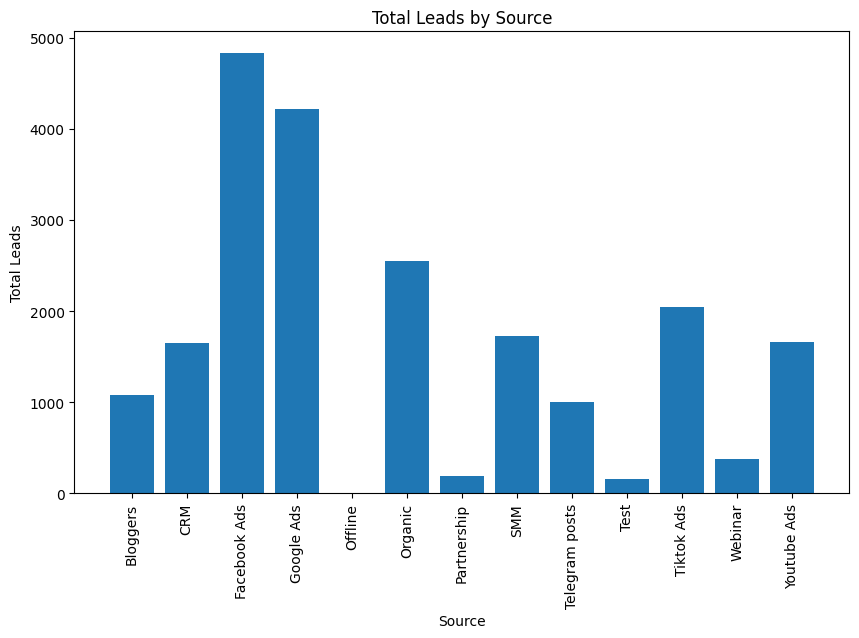

In [6]:
# 6. Визуализация данных
# График общего количества лидов по источникам
plt.figure(figsize=(10,6))
plt.bar(lead_quality['Source'], lead_quality['total_leads'])
plt.xlabel('Source')
plt.ylabel('Total Leads')
plt.title('Total Leads by Source')
plt.xticks(rotation=90)
plt.show()


### Анализ эффективности маркетинговых источников

**Общее количество лидов (Total Leads)**:
Наибольшее количество лидов было сгенерировано из источников Facebook Ads (4829 лидов) и Google Ads (4221 лид), что указывает на высокий охват 
и активное привлечение пользователей этими каналами.
Источники с наименьшим количеством лидов включают Offline (2 лида) и Partnership (191 лид), что может говорить о низкой активности или менее 
эффективных кампаниях в этих каналах.
    
**Количество качественных лидов (Quality Leads)**:
Источники Facebook Ads (274 качественных лида) и Google Ads (238 качественных лидов) также лидируют по количеству качественных лидов, 
что коррелирует с общим количеством лидов.
Organic и SMM также показывают высокие результаты с 189 и 132 качественными лидами соответственно.

**Коэффициент качества лидов (Quality Rate)**:
Самый высокий коэффициент качества показал Offline (50%), но это связано с очень низким количеством лидов (всего 2), из которых один 
оказался качественным.
Однако, с точки зрения статистики, такое малое количество данных делает эту оценку ненадежной.
Webinar показал высокий коэффициент качества лидов (9.76%), что может свидетельствовать о том, что вебинары привлекают более заинтересованных 
и готовых к покупке клиентов.
SMM (7.64%) и Organic (7.42%) также продемонстрировали хорошие результаты, что подчеркивает важность контент-маркетинга и органического трафика 
в привлечении качественных лидов.
Источники Partnership (1.05%) и CRM (1.93%) имеют самый низкий коэффициент качества лидов, что указывает на необходимость пересмотра стратегии 
использования этих каналов.

**Рекомендации**:
**Увеличение инвестиций в каналы с высоким качеством лидов**:
Рассмотреть возможность увеличения инвестиций в Webinar, SMM, и Organic каналы, так как они демонстрируют высокую эффективность в генерации 
качественных лидов.

**Оптимизация крупных каналов**:
Хотя Facebook Ads и Google Ads генерируют большое количество лидов, их коэффициент качества можно повысить за счет более целевых кампаний, 
что приведет к лучшей рентабельности инвестиций.

**Пересмотр или улучшение низкоэффективных каналов**:
Рассмотреть возможность оптимизации стратегии для CRM и Partnership, чтобы понять, почему они имеют низкий коэффициент качества лидов, 
и разработать подходы для улучшения их эффективности.

**Оценка источников с низким объемом данных**:
Для таких источников, как Offline, необходимо провести дополнительные исследования или запустить более масштабные тестовые кампании, 
чтобы получить более достоверные данные о их эффективности.
Этот анализ поможет вам более эффективно распределять маркетинговый бюджет и усилия на те каналы, которые приносят не только большое 
количество лидов, но и высокое качество, что приведет к увеличению конверсий и росту прибыли.

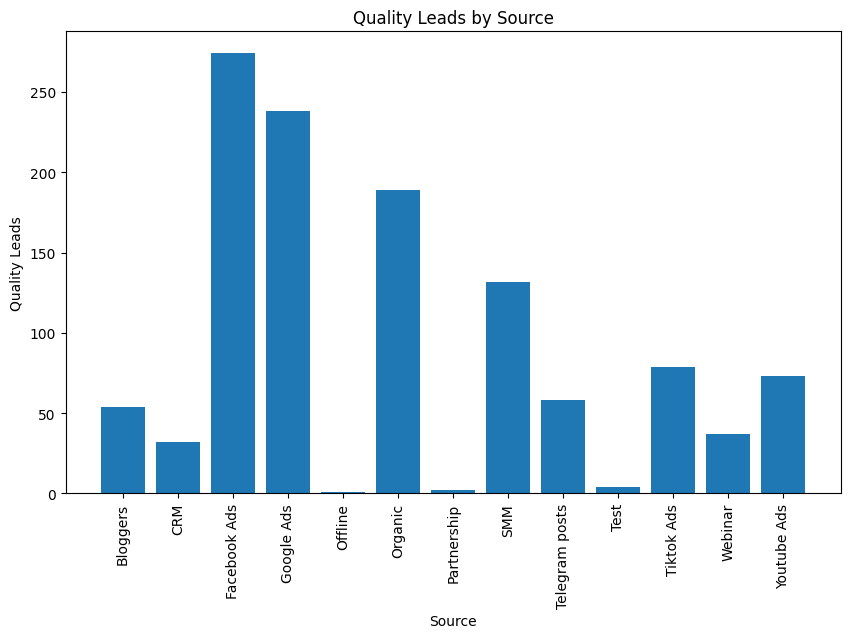

In [7]:
# График качественных лидов по источникам
plt.figure(figsize=(10,6))
plt.bar(lead_quality['Source'], lead_quality['quality_leads'])
plt.xlabel('Source')
plt.ylabel('Quality Leads')
plt.title('Quality Leads by Source')
plt.xticks(rotation=90)
plt.show()



### На предоставленном графике показано количество качественных лидов (Quality Leads) по различным источникам. 
Этот график дает представление о том, какие источники генерируют наибольшее количество лидов, которые можно считать качественными,
т.е. с высокой вероятностью конверсии в продажи.

**Основные выводы**:
**Лидеры по количеству качественных лидов**:
Facebook Ads: Этот источник генерирует наибольшее количество качественных лидов, около 274. Несмотря на средний коэффициент качества лидов, большой объем лидов делает этот источник важным для компании.
Google Ads: На втором месте по количеству качественных лидов находится Google Ads, с показателем около 238 лидов. Это подтверждает высокую эффективность этого канала, особенно учитывая его способность привлекать как большое количество лидов, так и высокое качество.

**Средние показатели**:
Organic и SMM также демонстрируют хорошие результаты, генерируя 189 и 132 качественных лида соответственно. Эти источники являются стабильными каналами для привлечения заинтересованных клиентов.
Youtube Ads и Telegram posts также показывают умеренное количество качественных лидов, что делает их важными второстепенными каналами.

**Источники с низким количеством качественных лидов**:
CRM, Partnership, и Test генерируют очень малое количество качественных лидов, что свидетельствует о низкой эффективности этих каналов. Это может указывать на необходимость пересмотра стратегии работы с этими источниками.
Offline также имеет низкое количество качественных лидов (всего 1), что связано с малым общим количеством лидов из этого источника. Это может быть результатом низкой активности этого канала или специфики данных.

**Интересные наблюдения**:
Webinar, несмотря на высокий коэффициент качества лидов, генерирует меньшее количество качественных лидов по сравнению с лидерами, такими как Facebook Ads и Google Ads. Это может означать, что вебинары привлекают меньше аудитории, но эта аудитория более целевая и качественная.

**Рекомендации**:
**Масштабирование успешных источников**:
Facebook Ads и Google Ads показали свою эффективность, генерируя наибольшее количество качественных лидов. Эти каналы следует рассматривать для дальнейшего увеличения бюджета и расширения кампаний.

**Оптимизация средних и малых источников**:
Organic, SMM, Youtube Ads и Telegram posts также являются важными источниками, но их эффективность может быть улучшена за счет дополнительных усилий в оптимизации таргетинга и креативов.
Источники с низким количеством качественных лидов, такие как CRM, Partnership, и Test, требуют анализа и возможного пересмотра стратегии. Возможно, стоит изменить подход к работе с этими каналами или сосредоточиться на более успешных источниках.

**Дополнительное исследование**:
Webinar: Несмотря на меньшее количество лидов, этот канал показывает высокий коэффициент качества. Стоит рассмотреть возможность проведения большего количества вебинаров или расширения их аудитории для привлечения большего числа качественных лидов.

**Сравнение с другими метриками**:
Следует сопоставить количество качественных лидов с другими метриками, такими как стоимость привлечения (CPL) и рентабельность (ROI), чтобы принять более взвешенные решения по распределению маркетингового бюджета.

**Заключение**:
График показывает, какие источники генерируют наибольшее количество качественных лидов. Это важный инструмент для оценки эффективности различных каналов и принятия решений о том, куда стоит инвестировать больше ресурсов. Важно сбалансировать количество и качество лидов, чтобы максимально повысить рентабельность маркетинговых кампаний.

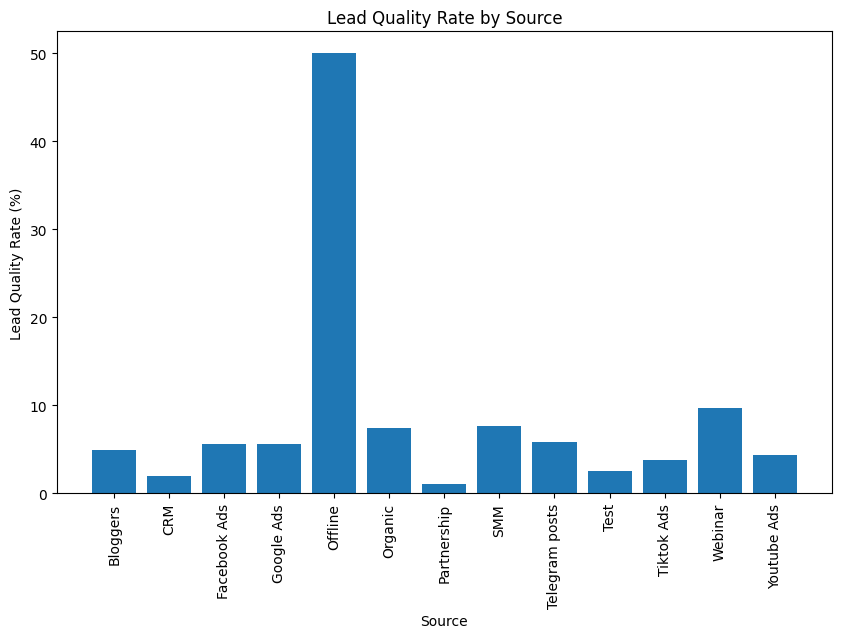

In [8]:
# График коэффициента качества лидов по источникам
plt.figure(figsize=(10,6))
plt.bar(lead_quality['Source'], lead_quality['quality_rate'])
plt.xlabel('Source')
plt.ylabel('Lead Quality Rate (%)')
plt.title('Lead Quality Rate by Source')
plt.xticks(rotation=90)
plt.show()

### На графике показан коэффициент качества лидов (Lead Quality Rate) по различным источникам. 

**Основные выводы**:

**Аномально высокий коэффициент качества у Offline**:
Источник Offline демонстрирует аномально высокий коэффициент качества лидов, достигающий 50%. Однако, как видно из предыдущего анализа, этот результат основан на очень малом количестве данных (всего два лида, из которых один качественный). Это делает этот результат статистически ненадежным и не подходящим для использования в принятии решений.

**Высокий коэффициент качества у Webinar**:
Webinar показывает один из самых высоких коэффициентов качества среди источников — около 9.76%. Это свидетельствует о том, что лиды, полученные через вебинары, имеют высокую вероятность быть конвертированными в качественные. Это подтверждает эффективность вебинаров как инструмента для привлечения заинтересованных клиентов.

**Умеренный коэффициент качества у Organic и SMM**:
Organic и SMM источники показывают умеренные коэффициенты качества лидов (7.42% и 7.64% соответственно). Это говорит о стабильной эффективности этих каналов для привлечения качественных лидов. Органический трафик и социальные медиа — это важные каналы, которые генерируют качественных лидов.

**Низкий коэффициент качества у CRM, Partnership, и Test**:
Источники CRM, Partnership, и Test имеют очень низкий коэффициент качества лидов (в районе 1-2%). Это указывает на низкую эффективность этих каналов в плане привлечения качественных лидов. Эти источники требуют детального анализа и возможной оптимизации или пересмотра.

**Равномерное распределение коэффициентов среди остальных источников**:
Большинство остальных источников, таких как Bloggers, Facebook Ads, и Google Ads, имеют коэффициенты качества на уровне 4-6%. Это средние показатели, которые указывают на определенную эффективность, но с возможностями для улучшения.

**Рекомендации**:
**Пересмотр и оптимизация низкоэффективных источников**:
Источники с низким коэффициентом качества лидов (CRM, Partnership, Test) требуют пересмотра. Возможно, потребуется изменить стратегию, таргетинг или контент, чтобы улучшить качество лидов, привлекаемых из этих источников.

**Масштабирование успешных источников**:
Источники с высоким коэффициентом качества, такие как Webinar, Organic, и SMM, следует рассматривать для масштабирования. Они демонстрируют высокую вероятность привлечения качественных лидов и, следовательно, могут принести значительную пользу при увеличении инвестиций.

**Оценка источника Offline**:
Несмотря на высокий коэффициент качества, источник Offline требует осторожности при интерпретации данных из-за малого количества выборки. Перед тем как принимать решения на основе этих данных, следует собрать больше данных и провести дополнительный анализ.

**Баланс между количеством и качеством**:
Важно не только ориентироваться на коэффициент качества лидов, но и учитывать общее количество лидов, чтобы находить баланс между привлечением большого объема лидов и их качеством.

**Заключение**:
График наглядно показывает эффективность различных источников в привлечении качественных лидов. Основное внимание стоит уделить оптимизации менее эффективных источников и масштабированию успешных. При этом необходимо учитывать контекст и особенности каждого источника, чтобы принимать взвешенные решения.